In [4]:
import datetime

from rocketpy import Environment, Flight, Function, MonteCarlo, Rocket, SolidMotor
from rocketpy.stochastic import (
    StochasticEnvironment,
    StochasticFlight,
    StochasticNoseCone,
    StochasticParachute,
    StochasticRailButtons,
    StochasticRocket,
    StochasticSolidMotor,
    StochasticTail,
    StochasticTrapezoidalFins,
)

# Environment
env = Environment(latitude=39.389700, longitude=-8.288964, elevation=113)
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.set_date((tomorrow.year, tomorrow.month, tomorrow.day, 12))
env.set_atmospheric_model(type="Ensemble", file="GEFS")


Total Impulse of the Solid Motor: 3216.021894 Ns


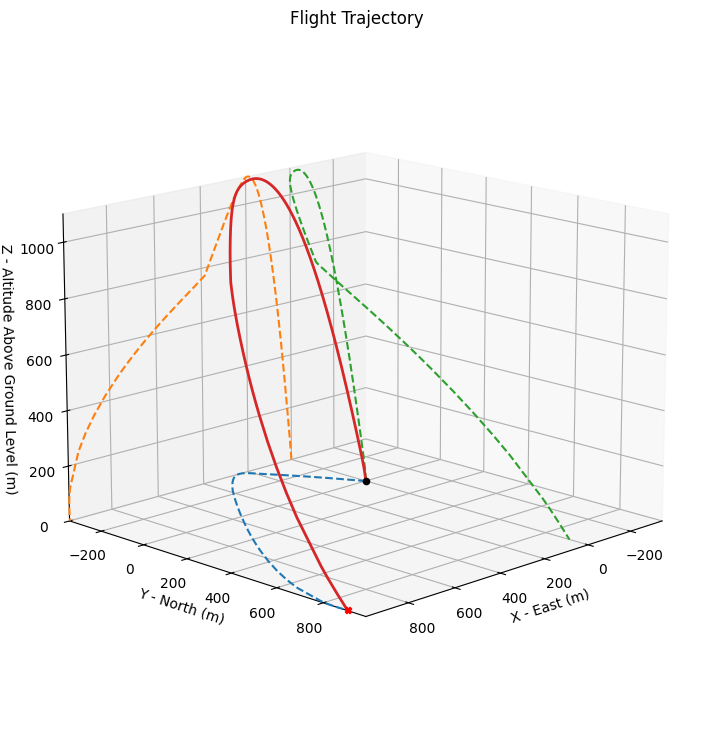


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 113.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.718 | e1: -0.001 | e2: 0.052 | e3: -0.694
Euler Angles - Spin φ : 45.00° | Nutation θ: -6.00° | Precession ψ: -133.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 2.194 c


Surface Wind Conditions

Frontal Surface Wind Speed: -3.30 m/s
Lateral Surface Wind Speed: 3.22 m/s


Launch Rail

Launch Rail Length: 5 m
Launch Rail Inclination: 84.00°
Launch Rail Heading: 133.00°


Rail Departure State

Rail Departure Time: 0.424 s
Rail Departure Velocity: 19.129 m/s
Rail Departure Stability Margin: 2.305 c
Rail Departure Angle of Attack: 13.281°
Rail Departure Thrust-Weight Ratio: 6.652
Rail Departure Reynolds Number: 1.773e+05


Burn out State

Burn out time: 2.040 s
Altitude at burn out: 251.611 m (ASL) | 138.611 m (AGL)
Rocket speed at burn out: 158.650 m/s
Freestream ve

In [15]:

# Motor
motor = SolidMotor(
    thrust_source="./L1553chasebismuth.eng",
    dry_mass=1.815,
    dry_inertia=(0.125, 0.125, 0.002),
    nozzle_radius=33 / 1000,
    grain_number=5,
    grain_density=1815,
    grain_outer_radius=33 / 1000,
    grain_initial_inner_radius=15 / 1000,
    grain_initial_height=120 / 1000,
    grain_separation=5 / 1000,
    grains_center_of_mass_position=0.397,
    center_of_dry_mass_position=0.317,
    nozzle_position=0,
    #burn_time=3.9,
    throat_radius=11 / 1000,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
print(f"Total Impulse of the Solid Motor: {motor.total_impulse} Ns")

# Rocket
rocket = Rocket(
    radius=127 / 2000,
    mass=14.426,
    inertia=(6.321, 6.321, 0.034),
    power_off_drag="./CD Power OFF Sustainer Only.csv",
    power_on_drag="./CD Power ON Sustainer only.csv",
    center_of_mass_without_motor=0,
    coordinate_system_orientation="tail_to_nose",
)

rail_buttons = rocket.set_rail_buttons(
    upper_button_position=0.0818,
    lower_button_position=-0.618,
    angular_position=45,
)

rocket.add_motor(motor, position=-1.255)

nose_cone = rocket.add_nose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = rocket.add_trapezoidal_fins(
    n=4,
    root_chord=0.120,
    tip_chord=0.060,
    span=0.110,
    position=-1.04956,
    cant_angle=0.5,
    #airfoil=("../../../data/airfoils/NACA0012-radians.txt", "radians"),
)

tail = rocket.add_tail(
    top_radius=0.0635, bottom_radius=0.0435, length=0.060, position=-1.194656
)
Main = rocket.add_parachute(
    "Main",
    cd_s=10.0,
    trigger=800,
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = rocket.add_parachute(
    "Drogue",
    cd_s=1.0,
    trigger="apogee",
    sampling_rate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

# Flight
test_flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=5,
    inclination=84,
    heading=133,
)

test_flight.plots.trajectory_3d()
test_flight.info()

In [8]:
stochastic_env = StochasticEnvironment(
    environment=env,
    ensemble_member=list(range(env.num_ensemble_members)),
)

stochastic_env.visualize_attributes()

Reporting the attributes of the `StochasticEnvironment` object:

Constant Attributes:
	datum                    SIRGAS2000
	elevation                113
	gravity                  Function from R1 to R1 : (height (m)) → (gravity (m/s²))
	latitude                 39.3897
	longitude                -8.288964
	timezone                 UTC

Stochastic Attributes:
	wind_velocity_x_factor   1.00000 ± 0.00000 (normal)
	wind_velocity_y_factor   1.00000 ± 0.00000 (normal)

Stochastic Attributes with choice of values:
	ensemble_member [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [9]:
wind_speed_at_1000m = []
for i in range(5):
    rnd_env = stochastic_env.create_object()
    wind_speed_at_1000m.append(rnd_env.wind_velocity_x(1000))

print(wind_speed_at_1000m)

[np.float64(9.498372704643668), np.float64(8.50503892812898), np.float64(8.160056343483927), np.float64(8.904456633180894), np.float64(8.178844975822495)]


In [10]:
stochastic_motor = StochasticSolidMotor(
    solid_motor=motor,
    burn_start_time=(0, 0.1, "binomial"),
    grains_center_of_mass_position=0.001,
    grain_density=50,
    grain_separation=1 / 1000,
    grain_initial_height=1 / 1000,
    grain_initial_inner_radius=0.375 / 1000,
    grain_outer_radius=0.375 / 1000,
    total_impulse=(6500, 1000),
    throat_radius=0.5 / 1000,
    nozzle_radius=0.5 / 1000,
    nozzle_position=0.001,
)
stochastic_motor.visualize_attributes()

Reporting the attributes of the `StochasticSolidMotor` object:

Constant Attributes:
	burn_out_time                    2.04
	center_of_dry_mass_position      0.317
	coordinate_system_orientation    nozzle_to_combustion_chamber
	dry_I_11                         0.125
	dry_I_12                         0
	dry_I_13                         0
	dry_I_22                         0.125
	dry_I_23                         0
	dry_I_33                         0.002
	dry_mass                         1.815
	grain_number                     5
	interpolate                      linear
	thrust_source                    [[0, 0], [0.0, 0.01], [0.03, 950.9609], [0.06, 970.4746], [0.09, 990.2287], [0.12, 1010.2221], [0.15, 1030.4536], [0.18, 1050.9219], [0.21, 1071.6254], [0.24, 1092.5624], [0.27, 1113.7312], [0.3, 1135.1297], [0.33, 1156.756], [0.36, 1178.6077], [0.39, 1200.6824], [0.42, 1222.9776], [0.45, 1245.4905], [0.48, 1268.2183], [0.51, 1291.1578], [0.54, 1314.3059], [0.57, 1337.6592], [0.6, 1361.2142]

In [11]:
stochastic_rocket = StochasticRocket(
    rocket=rocket,
    radius=0.0127 / 2000,
    mass=(15.426, 0.5, "normal"),
    inertia_11=(6.321, 0),
    inertia_22=0.01,
    inertia_33=0.01,
    center_of_mass_without_motor=0,
)
stochastic_rocket.visualize_attributes()

stochastic_nose_cone = StochasticNoseCone(
    nosecone=nose_cone,
    length=0.001,
)

stochastic_fin_set = StochasticTrapezoidalFins(
    trapezoidal_fins=fin_set,
    root_chord=0.0005,
    tip_chord=0.0005,
    span=0.0005,
)

stochastic_tail = StochasticTail(
    tail=tail,
    top_radius=0.001,
    bottom_radius=0.001,
    length=0.001,
)

stochastic_rail_buttons = StochasticRailButtons(
    rail_buttons=rail_buttons, buttons_distance=0.001
)

stochastic_main = StochasticParachute(
    parachute=Main,
    cd_s=0.1,
    lag=0.1,
)

stochastic_drogue = StochasticParachute(
    parachute=Drogue,
    cd_s=0.07,
    lag=0.2,
)

stochastic_rocket.add_motor(stochastic_motor, position=0.001)
stochastic_rocket.add_nose(stochastic_nose_cone, position=(1.134, 0.001))
stochastic_rocket.add_trapezoidal_fins(stochastic_fin_set, position=(0.001, "normal"))
stochastic_rocket.add_tail(stochastic_tail)
stochastic_rocket.set_rail_buttons(
    stochastic_rail_buttons, lower_button_position=(0.001, "normal")
)
stochastic_rocket.add_parachute(stochastic_main)
stochastic_rocket.add_parachute(stochastic_drogue)

stochastic_rocket.visualize_attributes()

Reporting the attributes of the `StochasticRocket` object:

Constant Attributes:
	I_12_without_motor              0
	I_13_without_motor              0
	I_23_without_motor              0
	coordinate_system_orientation   tail_to_nose
	power_off_drag                  Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)
	power_on_drag                   Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)

Stochastic Attributes:
	I_11_without_motor              6.32100 ± 0.00000 (normal)
	I_22_without_motor              6.32100 ± 0.01000 (normal)
	I_33_without_motor              0.03400 ± 0.01000 (normal)
	center_of_mass_without_motor    0.00000 ± 0.00000 (normal)
	mass                            15.42600 ± 0.50000 (normal)
	power_off_drag_factor           1.00000 ± 0.00000 (normal)
	power_on_drag_factor            1.00000 ± 0.00000 (normal)
	radius                          0.06350 ± 0.00001 (normal)
Reporting the attributes of the `StochasticRocke

Reporting the attributes of the `StochasticFlight` object:

Constant Attributes:
	rail_length           5

Stochastic Attributes:
	heading               53.00000 ± 2.00000 (normal)
	inclination           84.70000 ± 1.00000 (normal)
The following input file was imported: monte_carlo_class_example.inputs.txt
A total of 2 simulations results were loaded from the following output file: monte_carlo_class_example.outputs.txt

The following error file was imported: monte_carlo_class_example.errors.txt                                        
Starting Monte Carlo analysis                                              
Running Monte Carlo simulation with 2 workers.


c:\Users\E\Documents\GitHub\Procyon\rocketpy\venv\Lib\site-packages\rocketpy\simulation\monte_carlo.py:137: UserWarning: This class is still under testing and some attributes may be changed in next versions
  warnings.warn(


Results saved to monte_carlo_class_example.outputs.txt


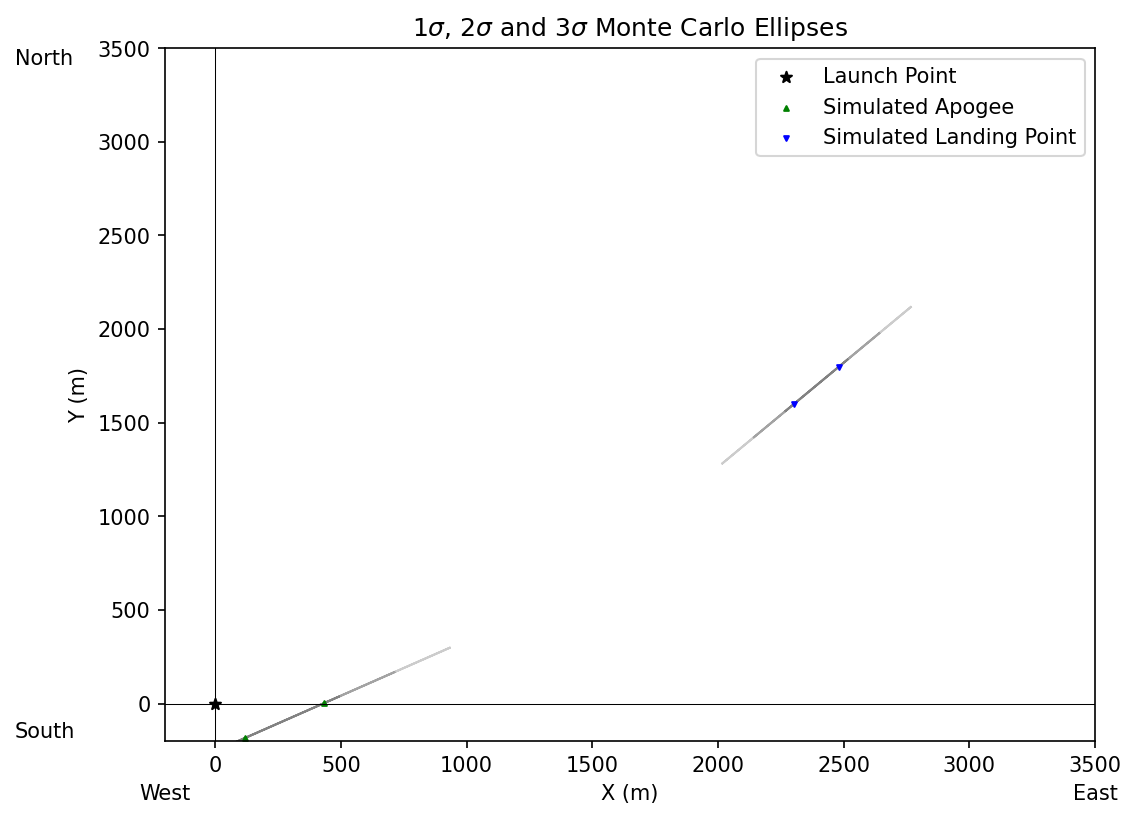

Monte Carlo Simulation by RocketPy
Data Source:  monte_carlo_class_example
Number of simulations:  2
Results: 

                Parameter            Mean          Median       Std. Dev.    95% PI Lower    95% PI Upper
--------------------------------------------------------------------------------------------------------------
                 x_impact        2392.124        2392.124          89.096        2307.483        2476.765
                   apogee        2627.265        2627.265          87.318        2544.313        2710.216
          max_mach_number           0.825           0.825           0.024           0.803           0.847
          impact_velocity          -5.214          -5.214           0.035          -5.247          -5.181
              apogee_time          21.903          21.903           0.299          21.619          22.187
 initial_stability_margin           2.560           2.560           0.041           2.522           2.599
         out_of_rail_time          

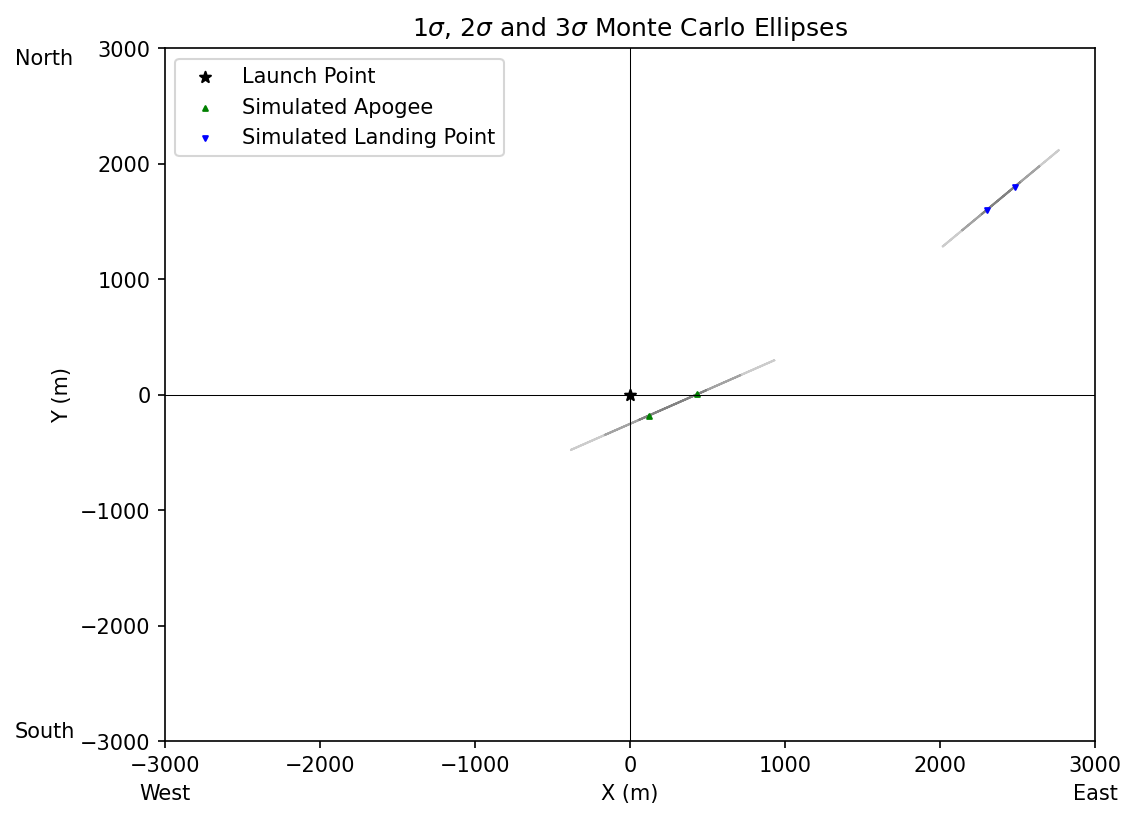

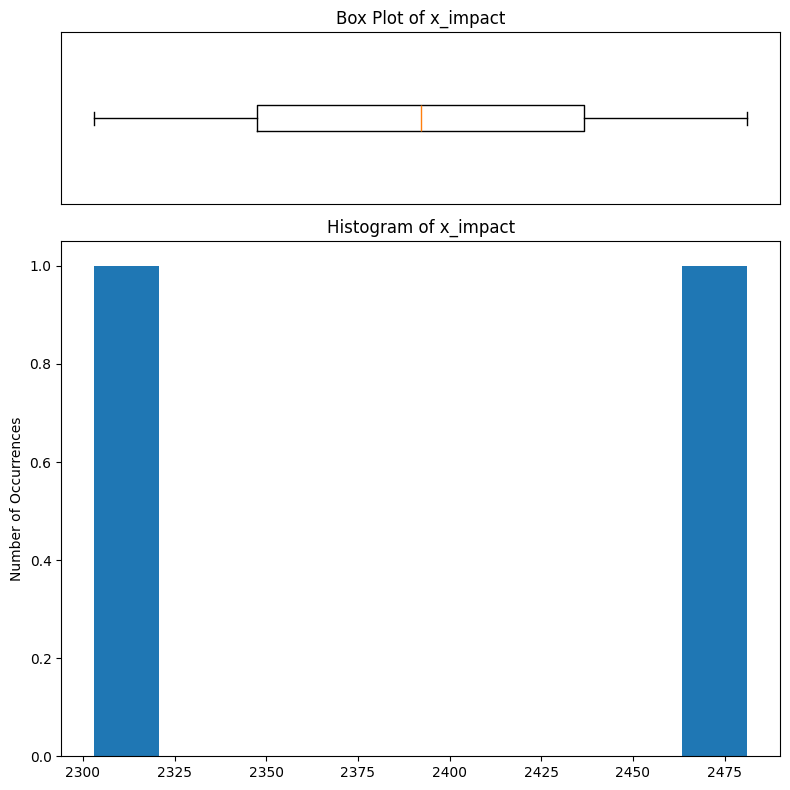

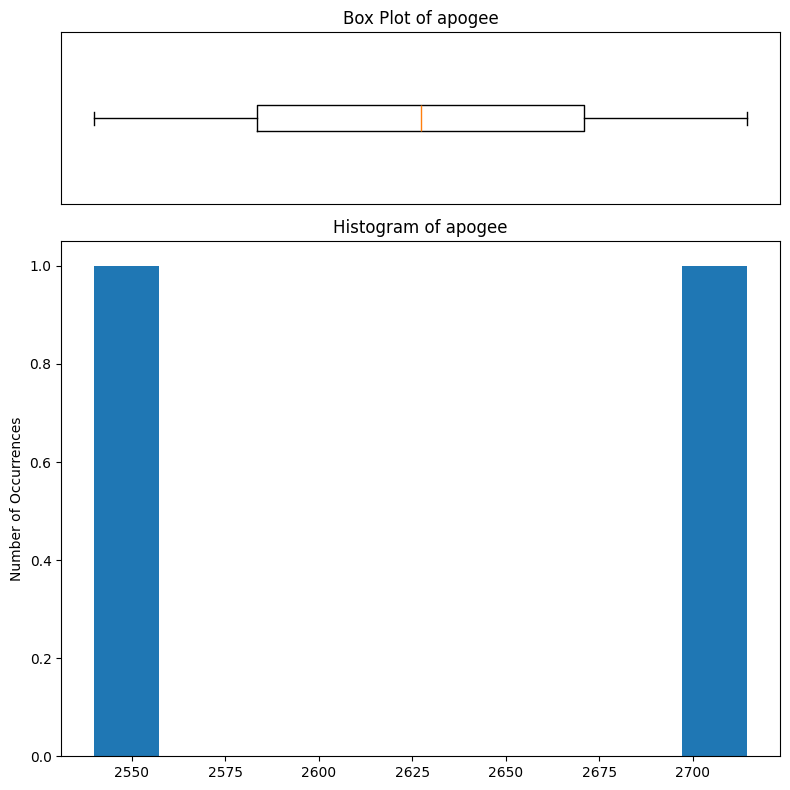

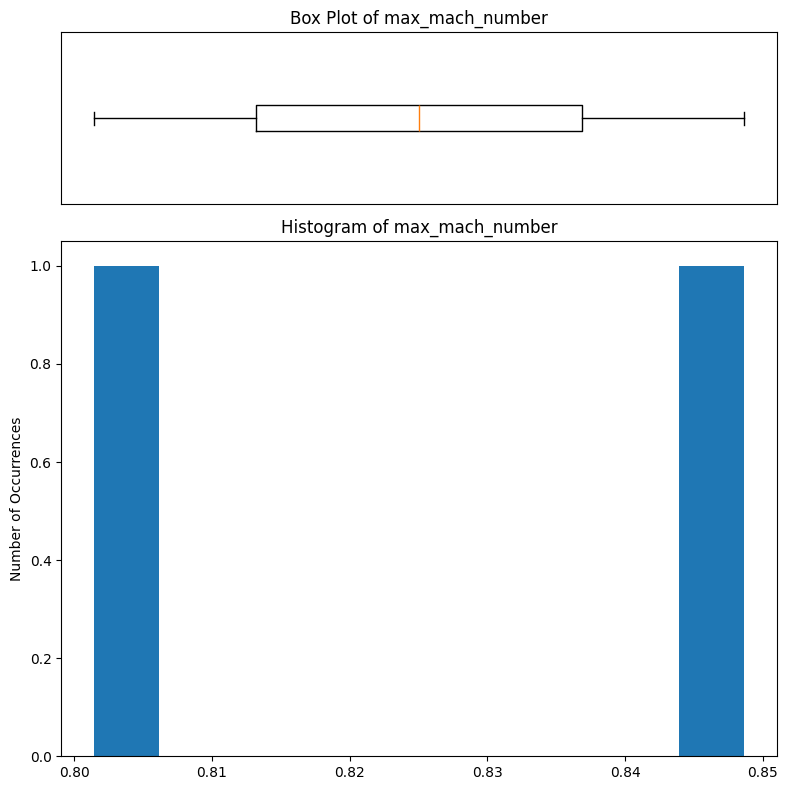

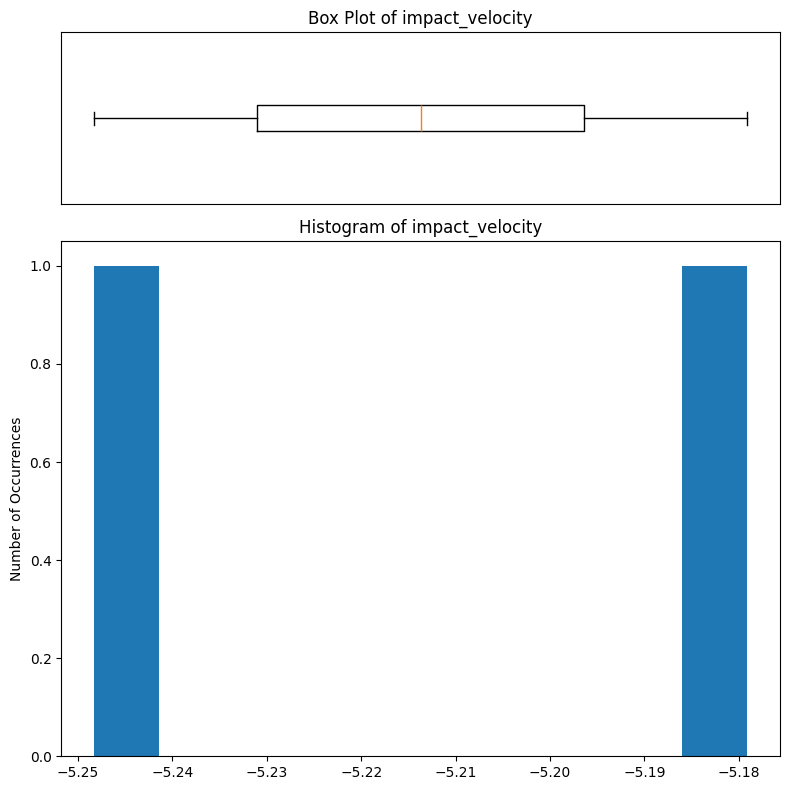

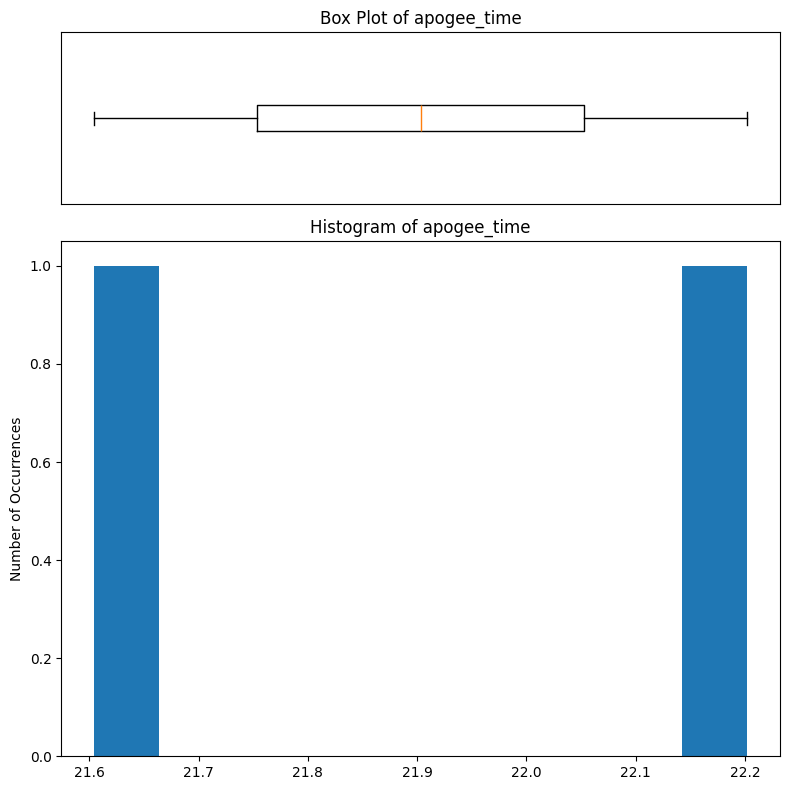

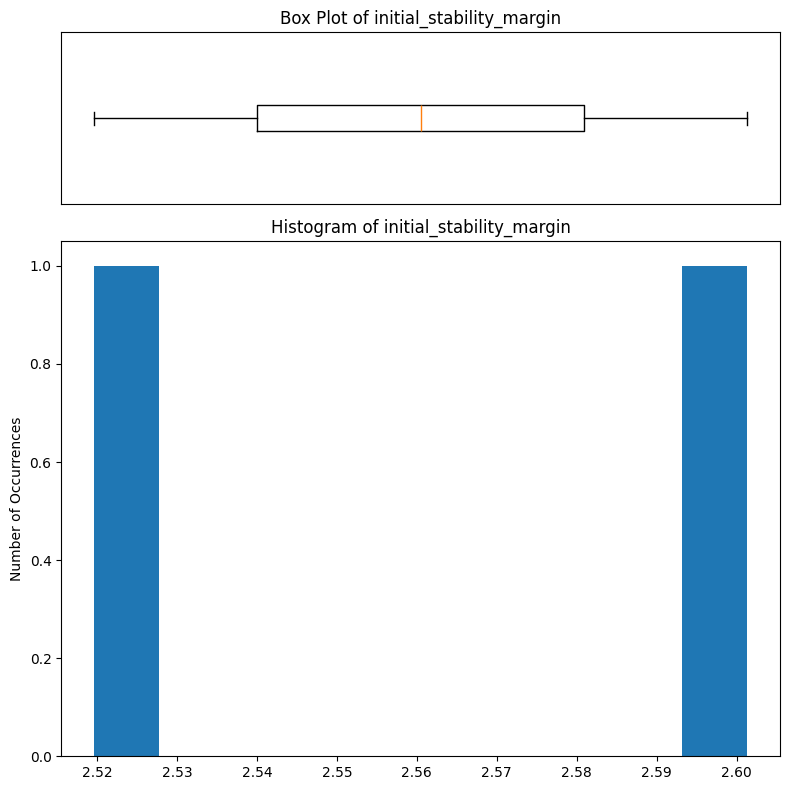

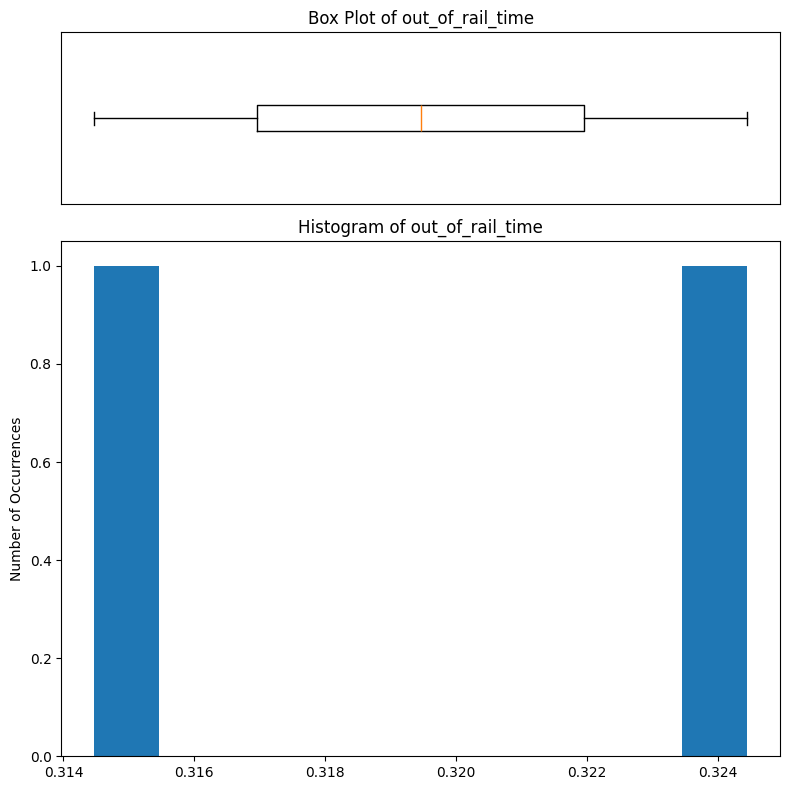

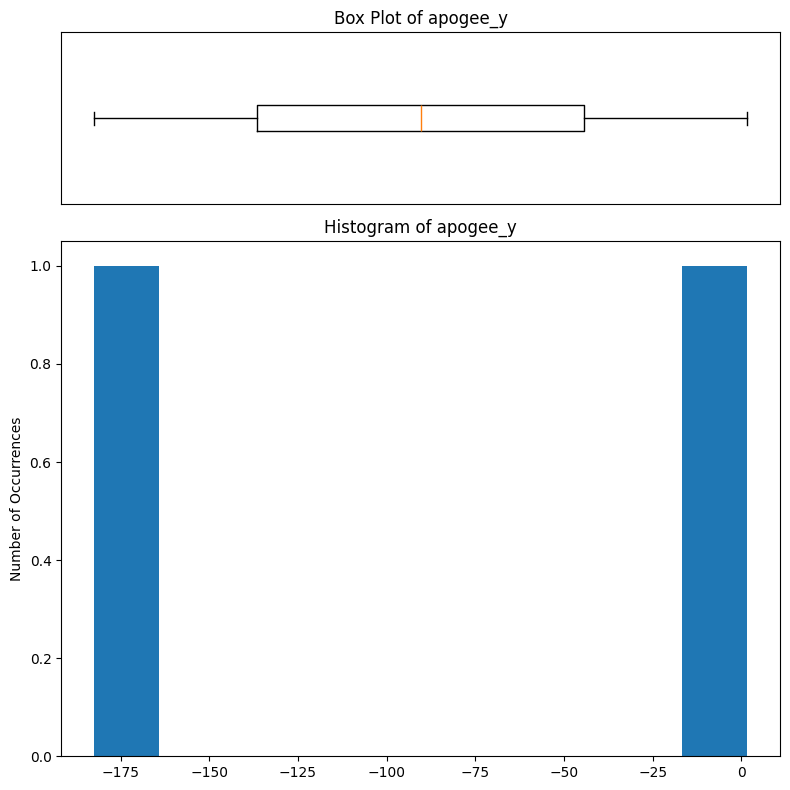

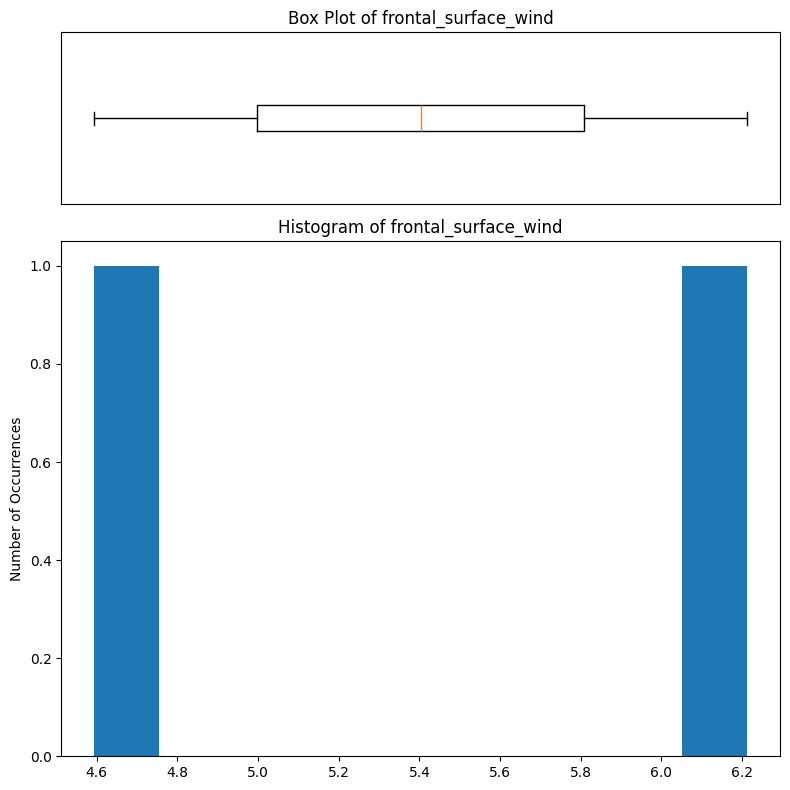

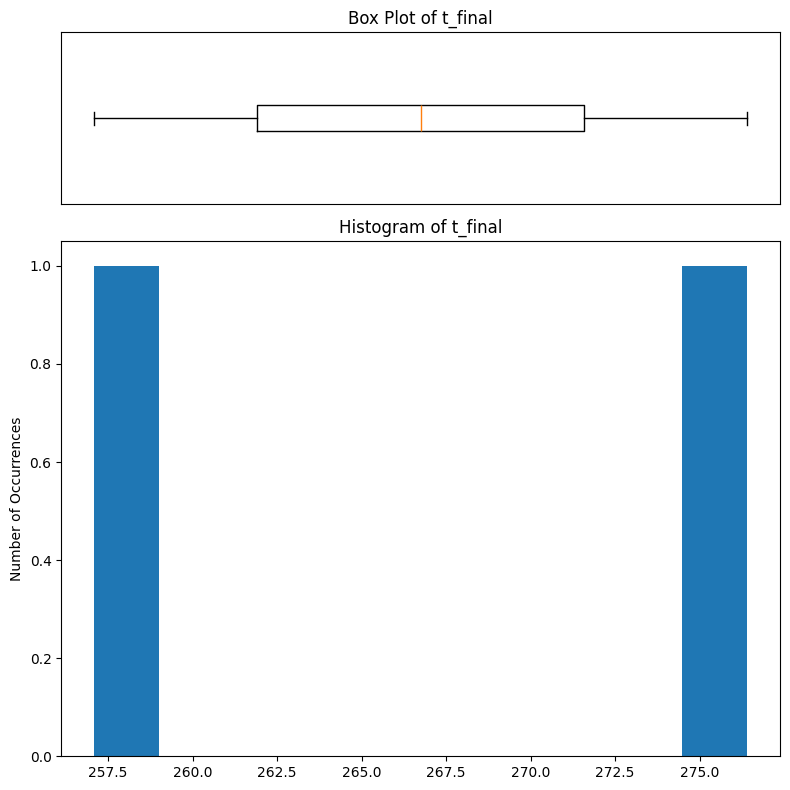

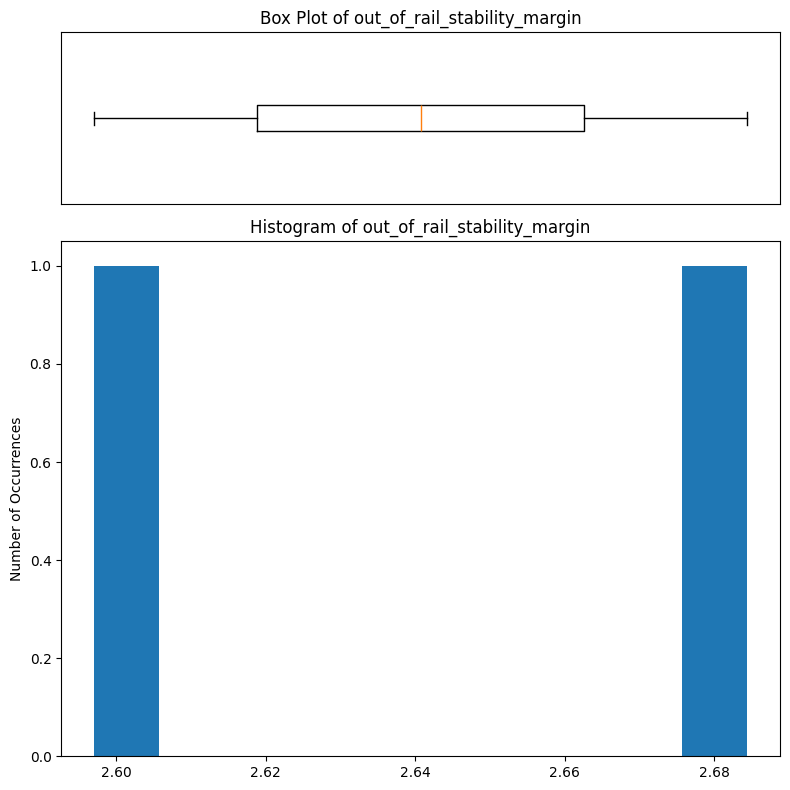

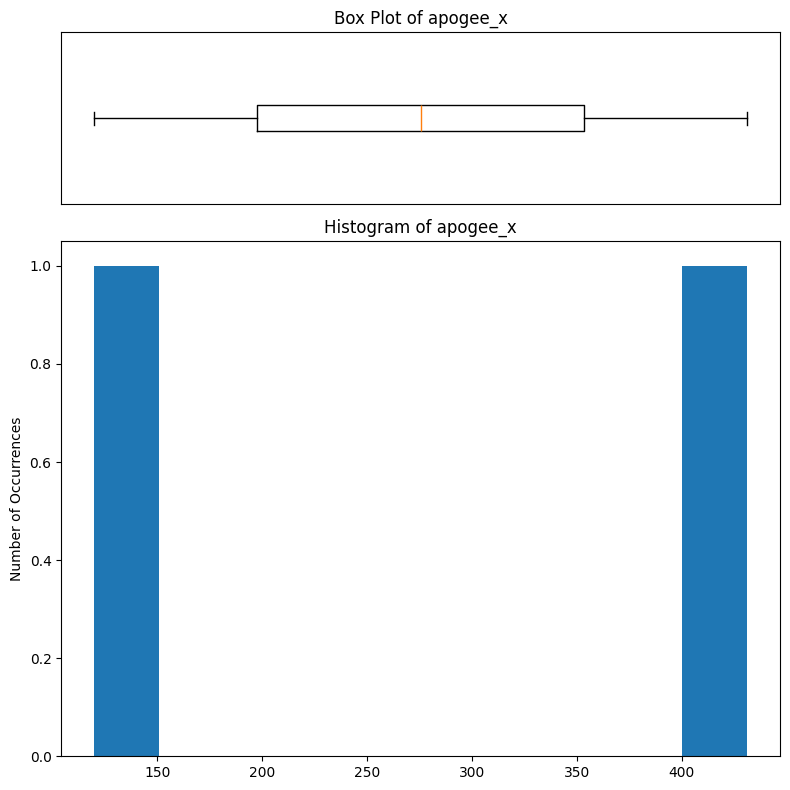

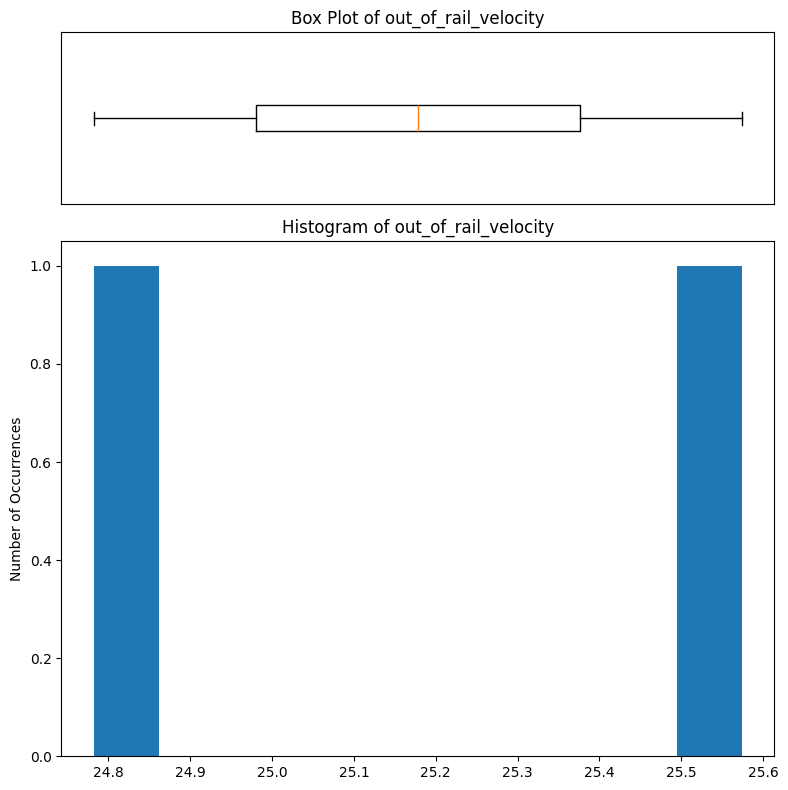

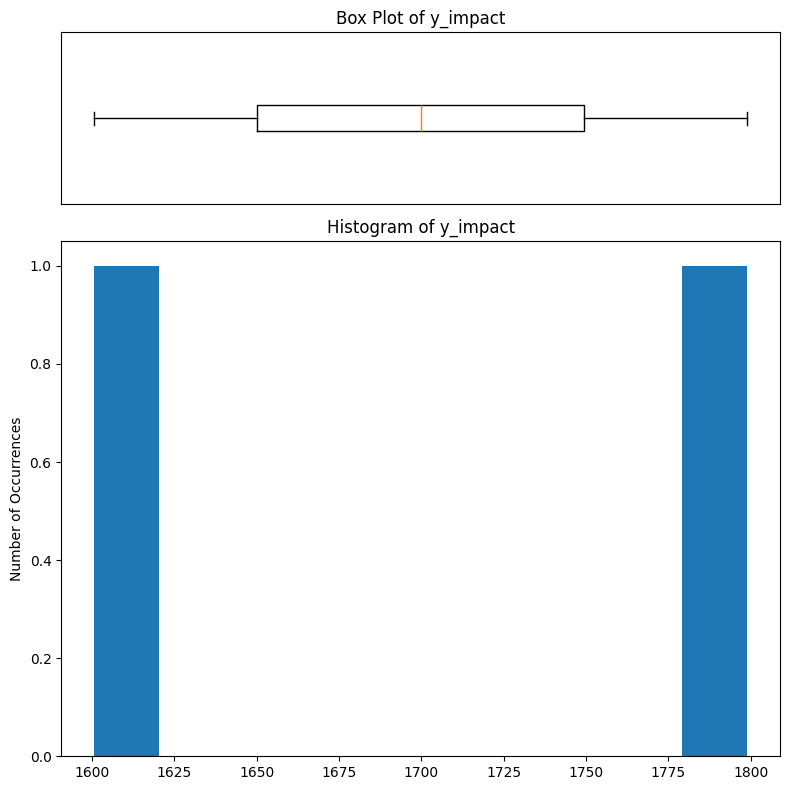

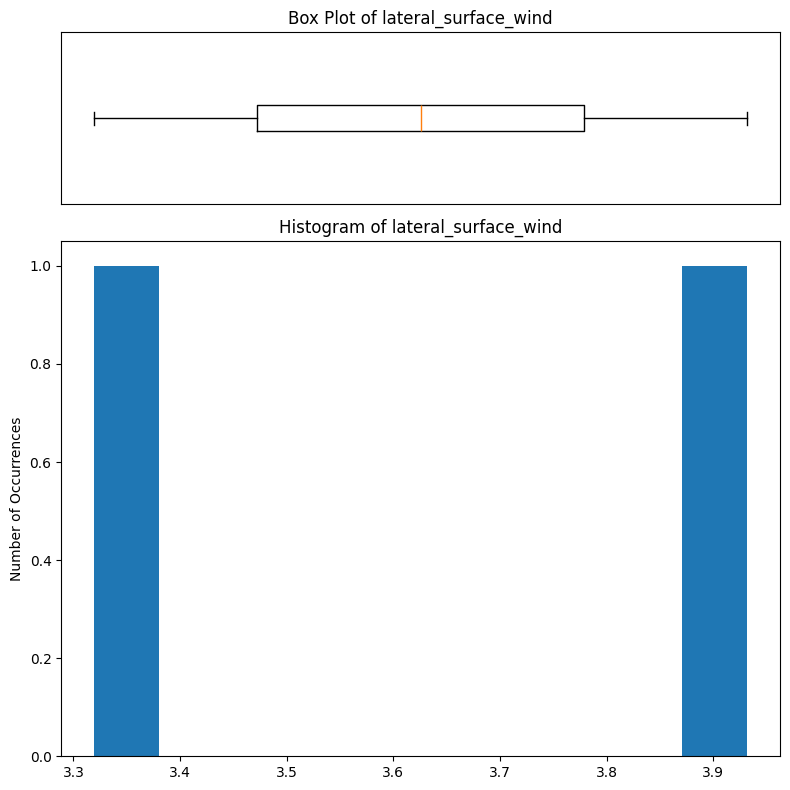

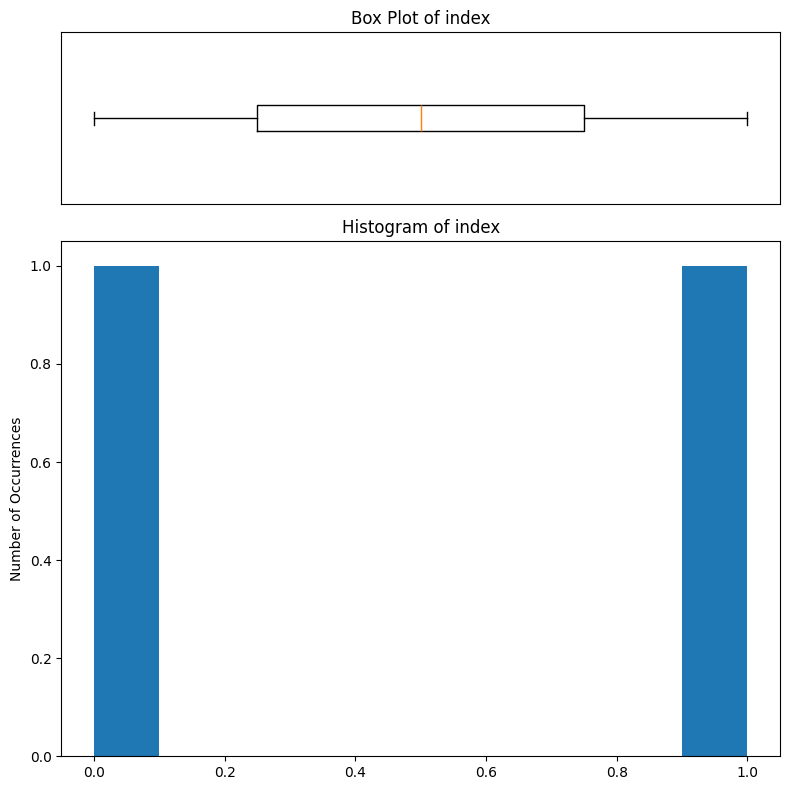

In [14]:
stochastic_flight = StochasticFlight(
    flight=test_flight,
    inclination=(84.7, 1),  # mean= 84.7, std=1
    heading=(53, 2),  # mean= 53, std=2
)
stochastic_flight.visualize_attributes()

test_dispersion = MonteCarlo(
    filename="./monte_carlo_class_example",
    environment=stochastic_env,
    rocket=stochastic_rocket,
    flight=stochastic_flight,
)

test_dispersion.simulate(
    number_of_simulations=2,
    append=False,
    include_function_data=False,
    parallel=True,
    n_workers=2,
)

test_dispersion.plots.ellipses(xlim=(-200, 3500), ylim=(-200, 3500))
test_dispersion.all_info()